# EPSCs NSFA Pipeline for Python # 




### Terminology ###


Different sized EPSCs can be **pooled**.
Decay periods across pooled EPSCs can be **combined**.
Items can be **binned** at the end to fit the parabola.

## Initialize File Names and Settings ##

Files should be  .txt tab delimited files of size (A,B) where each *column* B represents a single EPSC and *rows* A represent time points. All columns and rows must be the same length. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tabulate import tabulate

# Load data from a text file

# # # filename = "Text_EPSC.txt"  
# # filename = "Experimental_EPSCs_200.txt"
filename = "Simulated_EPSCs_CPCI.txt"
data = np.loadtxt(filename, delimiter="\t")


# Load data from an excel file
# Specify the path to your Excel file
# excel_file_path = 'Uncaging_EPSCs_aligned.xlsx'
# excel_file_path = 'Only Single EPSCs for NSFA_IEM CNQX.xlsx'

# # Use pandas to read the Excel file
# df = pd.read_excel(excel_file_path, sheet_name=4, header=None)
# print(df)

## Preprocessing ##

In [2]:
# ## Run Preprocessing Functions, defined in EPSC-Preprocessing-Script.ipynb

# %run EPSC-Preprocessing-Script.ipynb


In [3]:
# check1 = check_peak_alignment(unprocessed_EPSCs=df,peak_index=100)
# check2 = eliminate_double_peaks(unprocessed_EPSCs=check1,current_threshold=90, peak_index=100,time_threshold=100)

In [4]:
# # EXCEL BASED
# Convert the DataFrame to a numpy array
# data = check2.to_numpy()
# data = data * -1 
#number of time samples
num_samples = data.shape[0]
print(data.shape)

time_duration = 12  # in milliseconds, for experimental data
# time_duration = 16 #For simulated data

# Define the number of pools for different sized EPSCs
num_pools = 10

#Define the number of decay period segments
num_decay_segments = 20

#Define the number of traces
num_traces = data.shape[1]

#Define the number of bins for mean-variance pairs for parabola fitting
num_bins = 20

#Define ending point of decay segment. Default is end of trace. 
# end_decay_index = 140
end_index = num_samples

print(data)

(801, 199)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Create Template of Traces and Graph ##

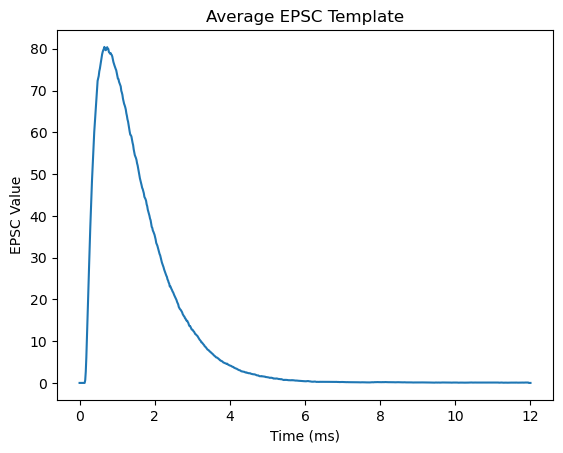

In [5]:

# Generate timepoints
timepoints = np.linspace(0, time_duration, num_samples)
# timepoints = np.linspace(0,600,600)
# print(timepoints)


# Extract EPSC values
EPSCs = data[:,:] #Shape is (sample_size,number_traces)

#Find the average EPSC from this
template = np.mean(EPSCs, axis =1) #Shape = (600,) 

plt.plot(timepoints,template)
plt.xlabel('Time (ms)')
plt.ylabel('EPSC Value')
plt.title('Average EPSC Template')
plt.savefig('Average-Template.png')
# plt.show()


## Find the Indexes of Decay Segments ##
- The decay segment time intervals are found by taking the maximum and minimum of the decay segment over the OVERALL TEMPLATE and dividing that by 20. That will define the boundaries of the segment indices
- Find the segment indices by seeing where the curve falls into those boundary lines. Array SEGMENT_INDICES should have 20 boundary indices in it. Check this. 

In [6]:
peak_index = np.argmax(template)

print("The sample index of the peak is: ", peak_index)
endPoint = template.shape[0] -1
template_decay_range = template[peak_index:endPoint]

decay_interval_width = (np.max(template_decay_range) - np.min(template_decay_range)) / num_decay_segments

# print("Decay Range: ", template_decay_range)

# print("The interval of the decay segments is: ", decay_interval_width)

peak = np.max(template_decay_range)
a = peak
cutoffs = [] 
for i in range(num_decay_segments):
    a = a - decay_interval_width
    cutoffs.append(a)
    
segment_indices = []
segment_indices.append(0)

for cutpoint in cutoffs: 
    index = 0 
    for value in template_decay_range: 
        if value <= cutpoint: 
            segment_indices.append(index-1)
            break
        index +=1 
segment_indices.append(endPoint)



print("The indices of the decay segment (w.rt peak) are: ", segment_indices) 
           

# segment_indices = [0,3,6,8,10,12,14,17,19,22,24,27,31,35,39,45,52,62,76,108,599]  #Manually from excel data for 11.txt, check with pipeline

    





The sample index of the peak is:  44
The indices of the decay segment (w.rt peak) are:  [0, 17, 25, 32, 39, 44, 51, 58, 64, 72, 79, 86, 95, 103, 113, 126, 140, 159, 182, 225, 752, 800]


## Visualize the EPSC Size Pools ##

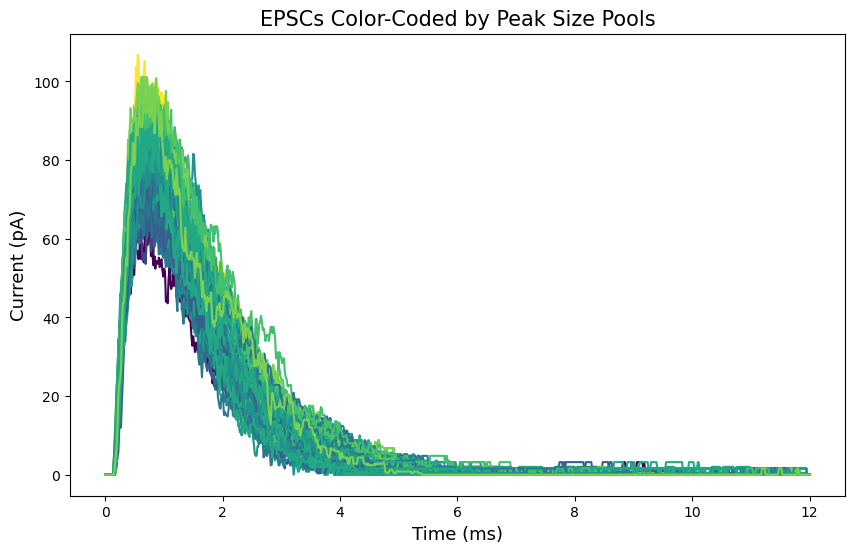

In [7]:
##VISUALIZATION
# Find the maximum values for each EPSC
max_values = np.max(EPSCs, axis=0)

# Calculate bin boundaries based on the maximum values of each trace
bin_width = (np.max(max_values) - np.min(max_values)) / num_pools
bin_boundaries = np.linspace(np.min(max_values), np.max(max_values) + bin_width, num_pools + 1)

# Assign each trace to a bin
trace_bins = np.digitize(max_values, bin_boundaries, right=True)


# Plot all traces color-coded by bin
plt.figure(figsize=(10, 6))

for i in range(EPSCs.shape[1]):
    plt.plot(timepoints, EPSCs[:, i], label=f'Trace {i + 1}', color=plt.cm.viridis(trace_bins[i] / num_pools))

plt.xlabel('Time (ms)',fontsize=13)
plt.ylabel('Current (pA)',fontsize=13)
plt.title('EPSCs Color-Coded by Peak Size Pools',fontsize=15)
plt.savefig('Traces-Color-Coded.png')
plt.show()




In [8]:
# ##VISUALIZATION
# df = df.to_numpy()

# # Find the maximum values for each EPSC
# max_values = np.max(df, axis=0)

# # Calculate bin boundaries based on the maximum values of each trace
# bin_width = (np.max(max_values) - np.min(max_values)) / num_pools
# bin_boundaries = np.linspace(np.min(max_values), np.max(max_values) + bin_width, num_pools + 1)

# # Assign each trace to a bin
# trace_bins = np.digitize(max_values, bin_boundaries, right=True)


# # Plot all traces color-coded by bin
# plt.figure(figsize=(10, 6))

# for i in range(EPSCs.shape[1]):
#     plt.plot(timepoints, df[:, i], label=f'Trace {i + 1}', color=plt.cm.viridis(trace_bins[i] / num_pools))

# plt.xlabel('Time (ms)')
# plt.ylabel('EPSC Value')
# plt.title('Traces Color-Coded by Peak Size Pools: Before Processing')
# plt.savefig('Traces-Color-Coded.png')
# plt.show()

# Method I of Variance Calculation # 

## Finding the Pooling and Segmenting Indices ##
- We divide the traces into 10 pools based on the size of the current, then 20 decay segments based on time SEGMENT_INDICES. 
- We need to AVERAGE for each one of these 200. RAW_BIN_AVERAGES should be an array with 200 data points.
- In this method, endPoint is added to the pool_indices because the final pool includes all of the array points to the end

In [9]:

#Sort the raw traces by their peaks from smallest to largest
print("Peak Index:", peak_index)
raw_sorted = EPSCs[:, EPSCs[peak_index, :].argsort()]

# current_interval_width = (np.max(raw_sorted[peak_index,:])-np.min(raw_sorted[peak_index,:]))/num_pools
# print(f"Max: {np.max(raw_sorted[peak_index,:])}, min: {np.min(raw_sorted[peak_index,:])}")
# pool_indices = []
# bin_cutoffs = []
# highest_peak = np.max(raw_sorted[peak_index ,:]) 
# cutoff = highest_peak 
# for i in range(10):
#     cutoff = cutoff - current_interval_width
#     bin_cutoffs.append(cutoff)

mini = np.min(raw_sorted[peak_index,:])
maxi = np.max(raw_sorted[peak_index,:])
bin_cutoffs = np.linspace(maxi,mini,num_pools+1)

bin_cutoffs = np.flip(bin_cutoffs) #Order it from smallest to largest
print("The pool cutoffs are: ", bin_cutoffs) #Confirmed the same as with excel doc

bins = []
pool_indices = []
for cutpoint in bin_cutoffs: 
    index = 0 
    for value in raw_sorted[peak_index,:] : 
        if value >= cutpoint: 
            pool_indices.append(index)
            print(f"The value that gives pool index {index} is {value}, checking for cutpoint {cutpoint}")
            break
        index +=1 


print("Pool Indices:", pool_indices) #this is the index of where the bins begin in terms of the peak row



#CONFIRMED EXPERIMENTAL: The pool cutoffs are:  [147.911  213.3796 278.8482 344.3168 409.7854 475.254  540.7226 606.1912
 #671.6598 737.1284]
#Pool Indices: [0, 7, 46, 97, 148, 165, 184, 192, 198, 199, 599] 


Peak Index: 44
The pool cutoffs are:  [ 54.    58.88  63.76  68.64  73.52  78.4   83.28  88.16  93.04  97.92
 102.8 ]
The value that gives pool index 0 is 54.0, checking for cutpoint 54.0
The value that gives pool index 2 is 60.4, checking for cutpoint 58.879999999999995
The value that gives pool index 5 is 64.4, checking for cutpoint 63.76
The value that gives pool index 17 is 69.2, checking for cutpoint 68.64
The value that gives pool index 42 is 73.6, checking for cutpoint 73.52
The value that gives pool index 77 is 78.4, checking for cutpoint 78.4
The value that gives pool index 125 is 83.6, checking for cutpoint 83.28
The value that gives pool index 165 is 88.4, checking for cutpoint 88.16
The value that gives pool index 185 is 93.2, checking for cutpoint 93.03999999999999
The value that gives pool index 194 is 98.0, checking for cutpoint 97.92
The value that gives pool index 198 is 102.8, checking for cutpoint 102.8
Pool Indices: [0, 2, 5, 17, 42, 77, 125, 165, 185, 194, 198]


### Calculating Means of Pools ###

Mean_Calculation parameters: 
- raw_sorted is an array of EPSCs where the columns (traces) have been sorted by the peak_index row. Type: np.array
- peak_index is the timepoint index where the peaks occur. Type: int
- endPoint is the final timepoint index. Type: int
- segment_indices is a list of decay segment indices. Type: list
- pool_indices is a list of integers indicating where the bin cutoff point for each pool is. Type: list
- analysis_type indicates which method of mean_variance analysis is being conducted. Type: int 
    - "0" indicates that Method I with no binning at the end (graph with black points) is being conducted
    - "1" indicates Method II (every individual EPSC has each decay block analyzed)
    - "2" indicates Method I for pooling
    - "3" indicates Method II for pooling

In [10]:
import math 


def mean_calculation(raw_sorted, peak_index,endPoint, segment_indices,pool_indices, analysis_type):
    if len(raw_sorted.shape) == 1:
        decay_data = raw_sorted[peak_index+1:endPoint]
    else:    
        decay_data = raw_sorted[peak_index+1:endPoint,:] #Sorted data within the range of the decay period (peak-endPoint)
    means = []
    i =0 
    j = 0 
    if analysis_type == 0:
        for i in range(len(segment_indices)-1): 
            row_lower = segment_indices[i]
            row_upper = segment_indices[i+1]
            for j in range(len(pool_indices)-1):
                column_lower = pool_indices[j]
                column_upper = pool_indices[j+1]
                #Check for edge case: Single trace in a pool 
                if column_lower == column_upper:
                    decay_block = decay_data[row_lower:row_upper,column_lower]
                else:
                    decay_block = decay_data[row_lower:row_upper, column_lower:column_upper]
                current_mean = np.mean(decay_block)
                means.append(current_mean)

    if analysis_type == 1: #Individual trace means 
        for i in range(num_traces):
            for j in range(len(segment_indices)-1): 
                row_lower = segment_indices[j]
                row_upper = segment_indices[j+1]
                decay_block = decay_data[row_lower:row_upper,i]
                current_mean = np.mean(decay_block)
                means.append(current_mean)
    if analysis_type == 3: #Indiviual pool analysis OR MA-P1-B20(pA) analysis
        for i in range(len(segment_indices)-1): 
            row_lower = segment_indices[i]
            row_upper = segment_indices[i+1]
            if len(raw_sorted.shape) == 1:
                decay_block = decay_data[row_lower:row_upper]
            else:
                decay_block = decay_data[row_lower:row_upper, :]
            current_mean = np.mean(decay_block)
            if np.isnan(current_mean).any():
                print("NAN detected")
            means.append(current_mean)
    if analysis_type == 4: #Individual trace means, but for pooling (Method II pool)
        means = np.zeros((len(segment_indices)-1,num_traces))
        for i in range(num_traces):
            for j in range(len(segment_indices)-1): 
                row_lower = segment_indices[j]
                row_upper = segment_indices[j+1]
                decay_block = decay_data[row_lower:row_upper,i]
                current_mean = np.mean(decay_block)
                means[j,i] = current_mean
#                 means.append(current_mean) 


            
    return means
    

    
means = mean_calculation(raw_sorted, peak_index,endPoint, segment_indices,pool_indices,0) #Length is Number of Traces X number of decay segments
print("Means:", means)

# means = mean_calculation(raw_sorted, peak_index,endPoint, segment_indices,pool_indices,4) 
# means_1 = mean_calculation(raw_sorted, peak_index,endPoint, segment_indices,pool_indices,1) 







Means: [60.388235294117656, 72.16470588235295, 70.13333333333334, 72.56282352941176, 77.12470588235294, 78.35833333333332, 82.65470588235294, 86.10705882352941, 87.67581699346405, 87.2058823529412, 57.7, 71.80000000000001, 67.73750000000001, 68.074, 73.10285714285715, 73.44583333333333, 77.235, 82.2, 79.9388888888889, 80.47500000000001, 53.28571428571428, 69.58095238095237, 65.1952380952381, 64.88914285714287, 69.6669387755102, 69.77619047619048, 73.38428571428572, 76.96285714285713, 76.27936507936506, 76.05714285714285, 54.74285714285714, 64.3047619047619, 59.92857142857144, 61.097142857142856, 65.20326530612246, 65.21666666666665, 69.21285714285713, 73.3457142857143, 72.49523809523811, 71.0142857142857, 51.36, 60.58666666666668, 56.233333333333334, 56.9696, 61.888, 60.97333333333333, 65.514, 69.68, 67.12, 64.44, 49.02857142857142, 57.44761904761904, 52.442857142857164, 53.49485714285714, 58.455510204081634, 57.4202380952381, 61.658571428571435, 63.67428571428572, 63.453968253968256, 

For every raw EPSC, we need to find the SCALED TEMPLATE that best fits it
Run MSE fitting to determine the coefficient that is best -- which scale ratio of the template results in the least difference between the template and the individual raw data trace

In [11]:
from scipy.optimize import minimize_scalar

EPSCs_sorted = EPSCs[:, EPSCs[peak_index, :].argsort()]


def objective(scale_factor, raw, average):
    max_raw = np.max(raw)
    max_average = np.max(average)
    term1 = (raw - average * scale_factor * (max_raw / max_average))**2
    return np.sum(term1)


#Another option for scaling of the template, this time to make the peaks match 
def peak_scaling(template,raw_trace):
    max_raw = np.max(raw_trace)
    max_template = np.max(template)
    scale_factor = max_raw/max_template
    return scale_factor
    


optimized_scale_factors = []
sum_residuals = []

for i in range(num_traces):

    raw_data = EPSCs_sorted[:,i]


    # Define bounds for the scale factor
    scale_factor_bounds = (0.85, 1.17)

    # Find the optimal scale factor
    result = minimize_scalar(objective, bounds=scale_factor_bounds, args=(raw_data, template)) 

    optimal_scale_factor = result.x
    minimized_value = result.fun
    #Find peak scaled
#     optimal_scale_factor = peak_scaling(template,raw_data)
    optimized_scale_factors.append(optimal_scale_factor)
    scaled_template = template*optimal_scale_factor
    sum_residuals.append(result.fun)

# sum_residuals = np.array(sum_residuals)  ## Equal to row 9632 of sheet 1, part 1
optimized_scale_factors = np.array(optimized_scale_factors)

def create_residual_array(scale_factor, raw, average):
    max_raw = np.max(raw)
    max_average = np.max(average)
    term1 = (raw - average * scale_factor * (max_raw / max_average))**2
    return term1


residuals_array = np.copy(EPSCs_sorted)
for i in range(num_traces):
    current_scale = optimized_scale_factors[i]
    residuals_array[:,i] = create_residual_array(current_scale, EPSCs_sorted[:,i], template)

# print(residuals_array)
#First value should match with Column DV Row 1807 (31768) 

# print(residuals_array[101:105,:])



## Calculation of Variance ##

Analysis Type 0 Chosen


Text(0, 0.5, 'Current variance (pA^2)')

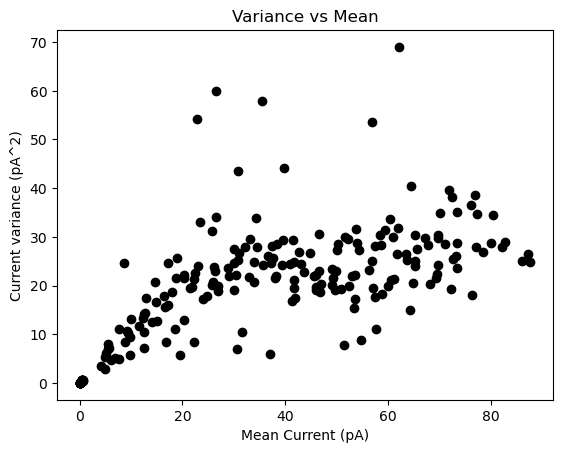

In [12]:


def var_calculation(peak_index, residuals_array,segment_indices,pool_indices,endPoint,analysis_type):
    decay_begin = peak_index + 1 #Starts one time point after the peak
    if len(residuals_array.shape) == 1:
        print("Calculating variance of 1D data")
        decay_data = residuals_array[decay_begin:endPoint] #total decay data
    else:    
        decay_data = residuals_array[decay_begin:endPoint,:] #total decay data

    variances = []

    if analysis_type == 0: 
        print("Analysis Type 0 Chosen")
        for i in range(len(segment_indices)-1): 
            row_lower = segment_indices[i]
            row_upper = segment_indices[i+1]
            for j in range(len(pool_indices)-1):
                column_lower = pool_indices[j]
                column_upper = pool_indices[j+1]
                #Check for edge case: Single trace in a pool 
                if column_lower == column_upper or len(residuals_array.shape) == 1:
#                     print(f"Columns {column_lower} to {column_upper}")
                    print("Edge case detected!")
                    decay_block = decay_data[row_lower:row_upper,column_lower]
                else:
                    decay_block = decay_data[row_lower:row_upper, column_lower:column_upper]
                sum_block = np.sum(decay_block)
                n = np.prod(np.shape(decay_block))
                #edge case check
                if n == 1: 
                    variances.append(0)
                else:
                    variance = sum_block/(n -1)
                    variances.append(variance)
                
    if analysis_type == 1: 
        print("Analysis Type 1 Chosen")
        for i in range(num_traces):
            for j in range(len(segment_indices)-1): 
                row_lower = segment_indices[j]
                row_upper = segment_indices[j+1]
                decay_block = decay_data[row_lower:row_upper,i]
                sum_block = np.sum(decay_block)
                n = np.prod(np.shape(decay_block))
                if n == 1: 
                    variances.append(0)
                else:
                    variance = sum_block/(n-1)
                    variances.append(variance)
    if analysis_type == 3: #Indiviual pool analysis 
        print("Analysis Type 3 Chosen")
        for i in range(len(segment_indices)-1): 
            row_lower = segment_indices[i]
            row_upper = segment_indices[i+1]
            if len(residuals_array.shape) == 1:
                print("Edge Case Detected: Single trace in pool.")
                decay_block = decay_data[row_lower:row_upper]
#                 print("Decay Block", decay_block)
            else:
                decay_block = decay_data[row_lower:row_upper, :]
            sum_block = np.sum(decay_block)
            n = np.prod(np.shape(decay_block))
            if n == 1: 
                print("N=1 detected")
                variances.append(0)
            else:
                variance = sum_block/(n-1)
                variances.append(variance)
    if analysis_type == 4: 
        print("Analysis Type: Individual Traces (Pooling) Chosen")
        variances = np.zeros((len(segment_indices)-1,num_traces))
        for i in range(num_traces):
            for j in range(len(segment_indices)-1): 
                row_lower = segment_indices[j]
                row_upper = segment_indices[j+1]
                decay_block = decay_data[row_lower:row_upper,i]
                sum_block = np.sum(decay_block)
                n = np.prod(np.shape(decay_block))
                if n == 1: 
                    variances[j,i] = 0
                else:
                    variance = sum_block/(n-1)
                    variances[j,i] = variance
    
        
    return variances
            

variances = var_calculation(peak_index, residuals_array,segment_indices,pool_indices,endPoint,0)
                             
# variances_4 = var_calculation(peak_index, residuals_array,segment_indices,pool_indices,endPoint,4)
# variances_1 = var_calculation(peak_index, residuals_array,segment_indices,pool_indices,endPoint,1)
# variances.sort()
# print(len(means))
# print(len(variances))
# print(variances)



plt.scatter(means,variances, color='black')
plt.title("Variance vs Mean")
plt.xlabel("Mean Current (pA)")
plt.ylabel("Current variance (pA^2)")




### Mean-variance pairs are sorted by mean from smallest to largest. ###

[121.5296272   0.       ]


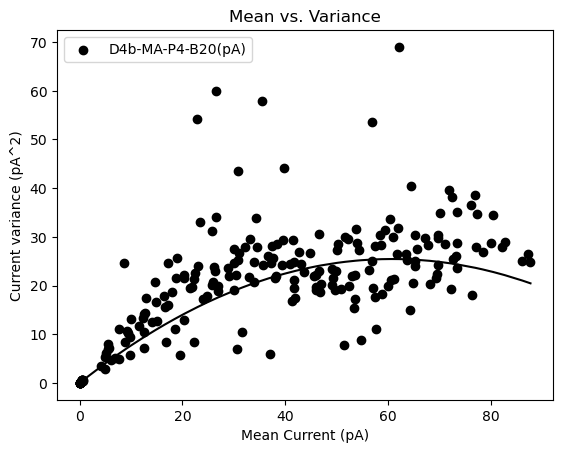

Coefficients of the original polynomial: [-0.00689177  0.83755377  0.        ]
Coefficients of the derivative line: [-0.01378353  0.83755377]
Initial slope at x=0: 0.8375537725002381


In [13]:
mean_var_pairs = list(zip(means, variances))

# Sort the resulting list of tuples by the list1 elements

sorted_pairs = sorted(mean_var_pairs, key=lambda x: x[0])
sorted_pairs = np.array(sorted_pairs)


# num_groups = 20 

group_means = []
group_variances = []

for i in range(0, len(means), 10):
    group_slice = sorted_pairs[i:i+10]
    slice_mean = np.mean(group_slice[:,0])
    group_means.append(slice_mean)
    slice_variance = np.mean(group_slice[:,1])
    group_variances.append(slice_variance)
    

group_mean_vars = list(zip(group_means,group_variances)) #Confirmed with excel


x_fit = group_means
y_fit = group_variances



# Perform linear regression
coefficients = np.polyfit(x_fit, y_fit, 1)
fit_line = np.poly1d(coefficients)


#Perform parabolic regression
coefficients_2 = np.polyfit(means,variances,2)
coefficients_2[2] = 0
fit_parabola = np.poly1d(coefficients_2)
roots = np.roots(coefficients_2)
print(roots)

# # Plot the scatterplot for the binned means and variances. There are 10 mean-variance pairs in each group. 
# plt.scatter(group_means,group_variances, color = 'red', label = 'Sorted by means into groups of 10')

# # Plot the linear line fit to the red points
# plt.plot(x_fit, fit_line(x_fit), color='red', label='Linear Fit')

#This is the function definition for the parabola fit to the individual pairs
poly=np.poly1d(np.polyfit(means, variances, 2))

##Repetition of the black plot of all the individual mean-variance pairis
plt.scatter(means,variances, color='black', label = 'D4b-MA-P4-B20(pA)')
sorter = np.sort(means)
plt.plot(sorter, fit_parabola(sorter),color='black')


# Labeling and legend
plt.xlabel("Mean Current (pA)")
plt.ylabel("Current variance (pA^2)")
plt.title('Mean vs. Variance')
plt.legend()
plt.savefig('Mean-Variance.png')

# Display the plot
plt.show()


# Define the derivative of the linear line
derivative_coefficients = np.polyder(coefficients_2)

# Create a function representing the derivative
derivative_function = np.poly1d(derivative_coefficients)

# Calculate the initial slope at a specific point (e.g., x=1)
initial_slope = derivative_function(0)

print("Coefficients of the original polynomial:", coefficients_2)
print("Coefficients of the derivative line:", derivative_coefficients)
# print("Coefficients of linear line:",coefficients)
print("Initial slope at x=0:", initial_slope)

## Parabolic Fits for Different Size Pools ##

Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
Analysis Type 3 Chosen
[26.507538565454432, 34.420179938135405, 36.5918057662532, 28.55429582633667, 40.52419448897677, 69.01069935163252, 18.22051216281405, 17.324207673186894, 19.377521920571162, 22.211267637234666, 21.04135041439028, 28.05328860944532, 27.890494533606354, 31.148976886424414, 33.007431787050756, 22.215484732241226, 24.61284536625772, 11.73288355647767, 4.671229645637877, 0.4527741061567003, 0.0]


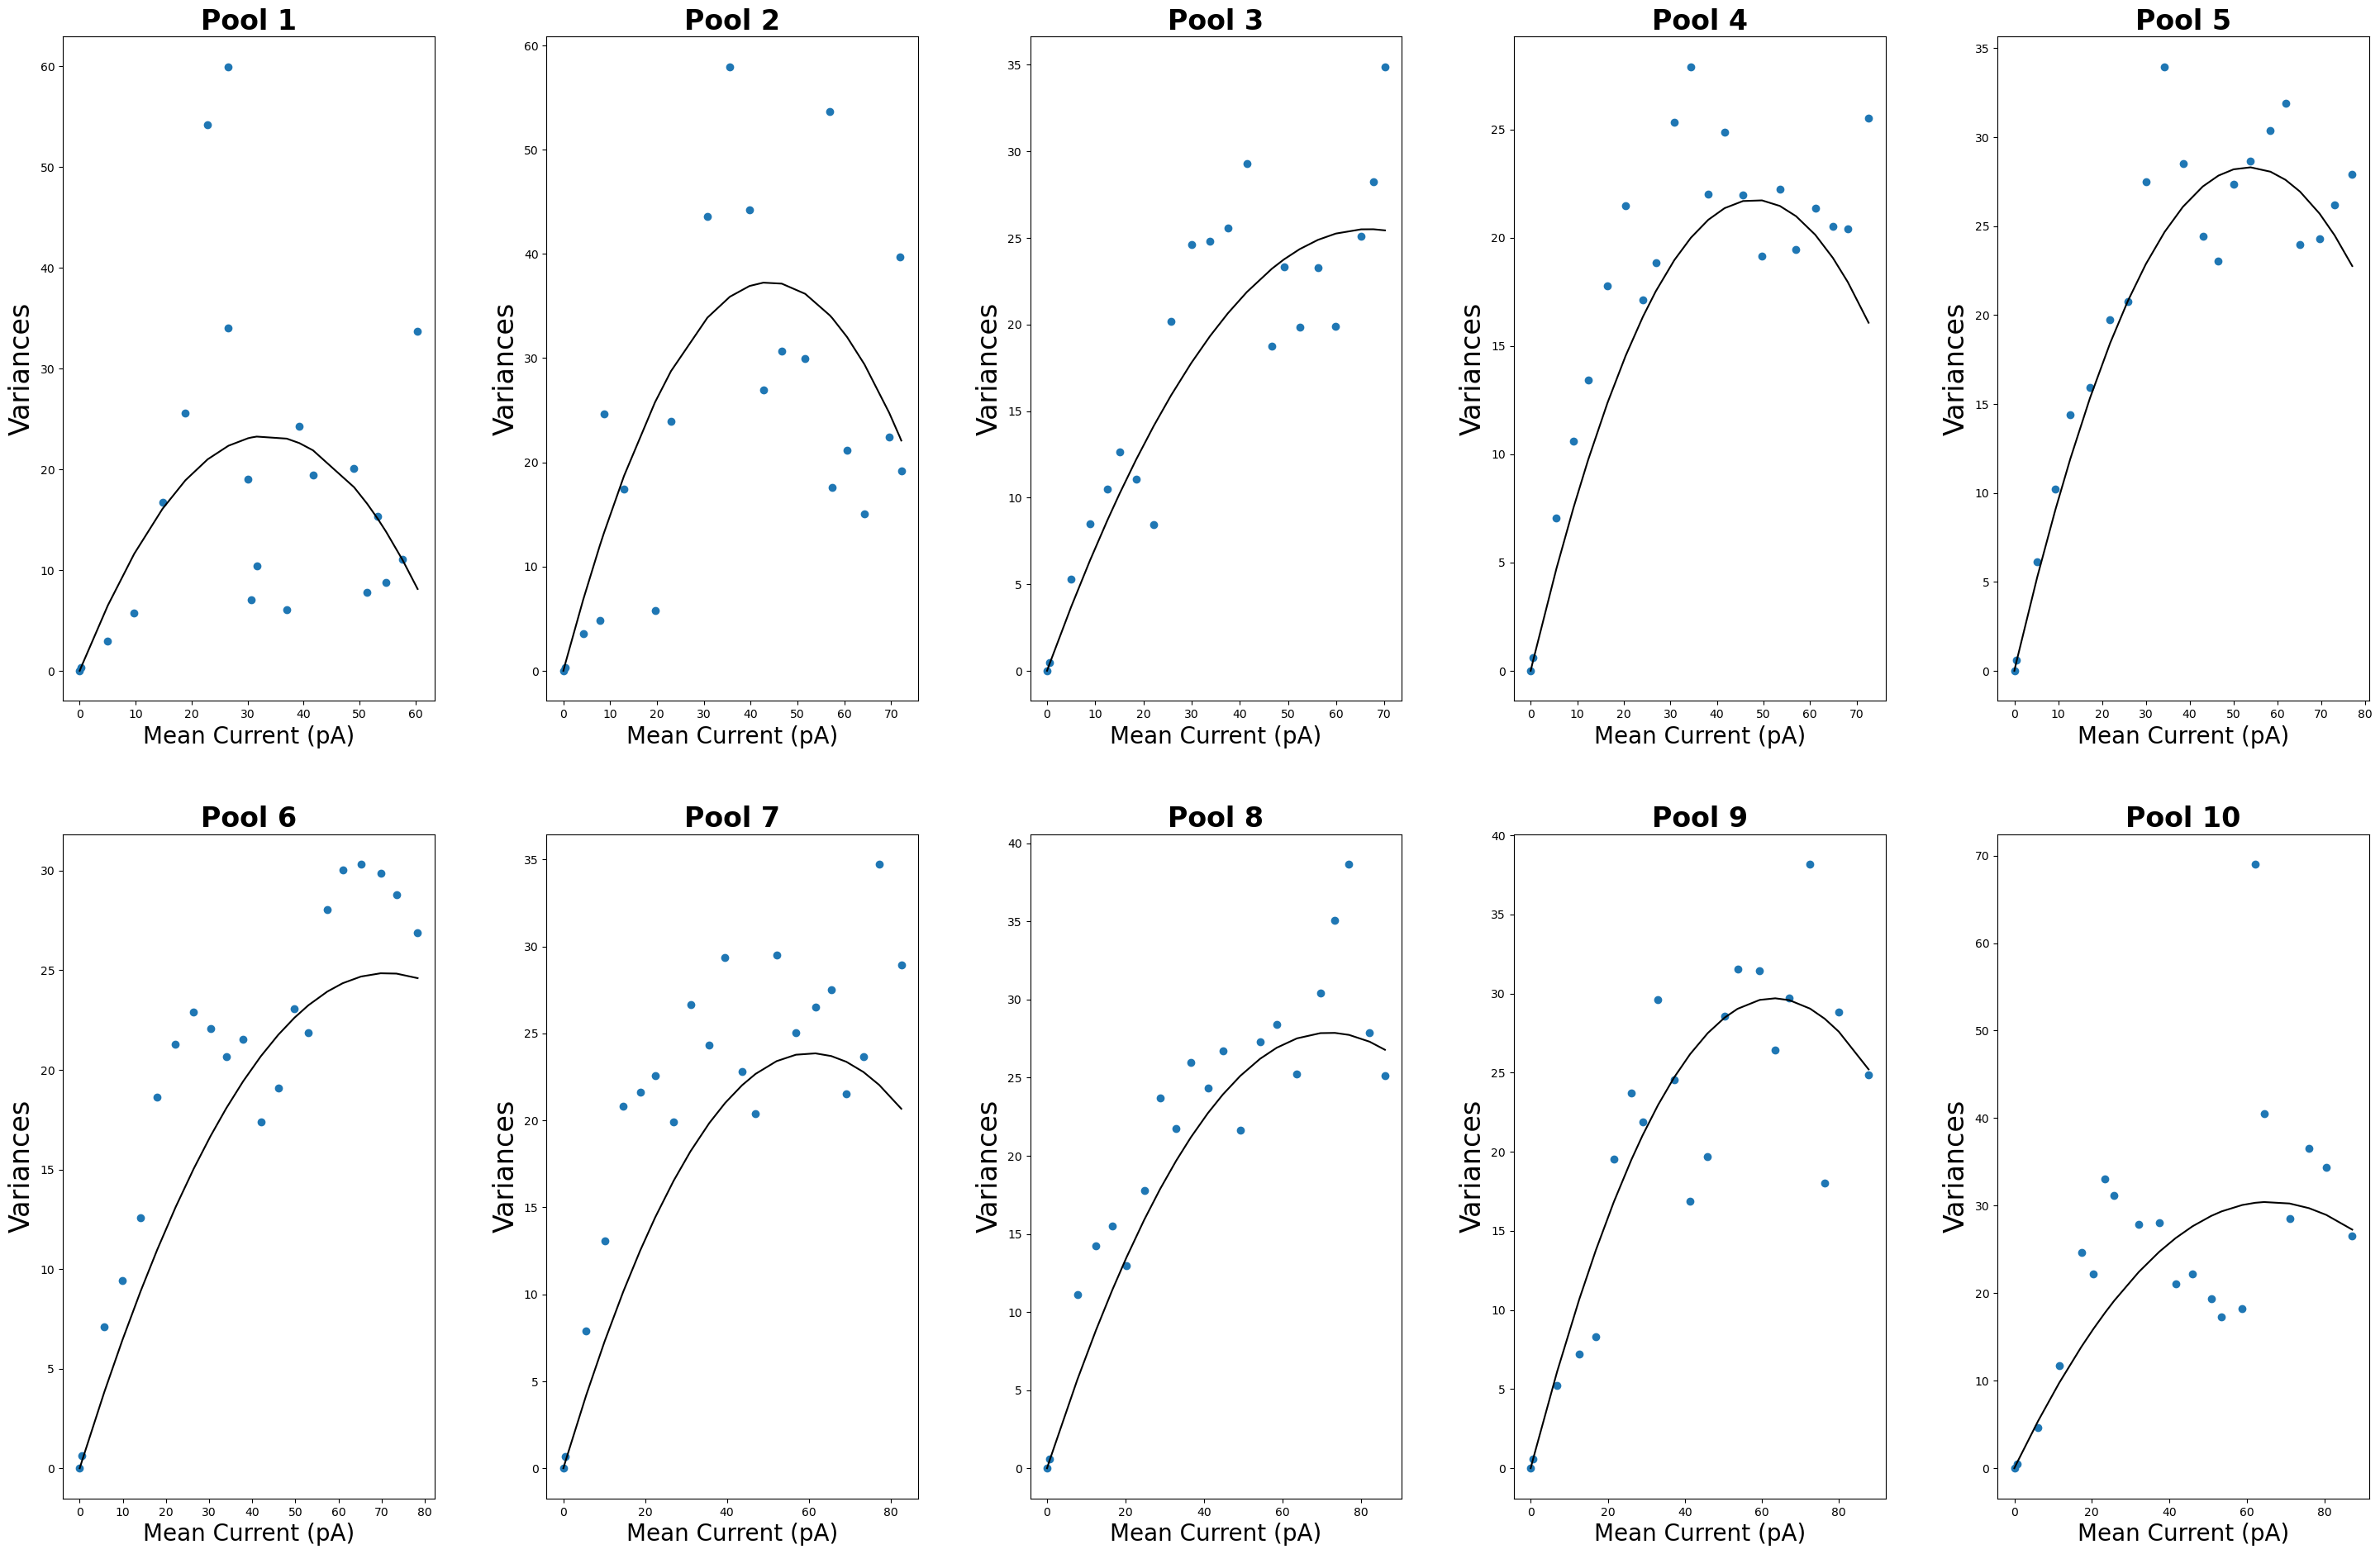

In [14]:
from scipy.optimize import curve_fit
from sklearn.model_selection import KFold
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from tabulate import tabulate

def quadratic_function(x, a, b):
    return a * x**2 + b * x

def regularized_quadratic_function(x, a, b, alpha):
    # Add L2 regularization penalty term to the objective function for the 'a' coefficient only
    regularization_term = alpha * a**2
    return a * x**2 + b * x + regularization_term


def quadratic_function(x, a, b):
    return a * x**2 + b * x 

# Set the bounds for optimization
bounds = ([-np.inf, -np.inf], [-.0001, np.inf])

# Perform k-fold cross-validation using cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the range of alpha values to test
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0]

def mse_for_alpha(alpha, means, variances):
    # Define a function to calculate mean squared error for a given alpha
    scores = []

    for train_index, test_index in kf.split(means):
        X_train, X_test = means[train_index], means[test_index]
        y_train, y_test = variances[train_index], variances[test_index]
        
        # Fit the model with regularization
        v_regularized = curve_fit(lambda x, a, b: regularized_quadratic_function(x, a, b, alpha), X_train, y_train, bounds=bounds)
#         v_regularized = curve_fit(lambda x, a, b: quadratic_function(x, a, b), X_train, y_train, bounds=bounds)

        co_regularized = np.append(v_regularized[0], 0)
        fit_parab_regularized = np.poly1d(co_regularized)
        
        # Compute the mean squared error on the test set
        mse = np.mean((fit_parab_regularized(X_test) - y_test)**2)
        scores.append(mse)

    return np.mean(scores)

multi_means_list = []
multi_var_list = []

#Means calculation

for index in range(len(pool_indices)-1): 
    column_lower = pool_indices[index]
    column_upper = pool_indices[index+1]
    if column_lower == column_upper:  #Check for edge case
        pool_segment = raw_sorted[:, column_lower]
    else:
        pool_segment = raw_sorted[:, column_lower:column_upper]
    pool_mean = mean_calculation(pool_segment, peak_index,endPoint, segment_indices,pool_indices, 3)
    multi_means_list.append(pool_mean)
    
#Variance calculation
for index in range(len(pool_indices)-1): 
    column_lower = pool_indices[index]
    column_upper = pool_indices[index+1]
    if column_lower == column_upper:  #Check for edge case
        pool_segment = residuals_array[:, column_lower]
#         print("Pool segment shape:", pool_segment.shape)
#         print("edge case detected")
    else:
        pool_segment = residuals_array[:, column_lower:column_upper]
    pool_var = var_calculation(peak_index, pool_segment,segment_indices,pool_indices,endPoint,3)
    multi_var_list.append(pool_var)

##Plotting
if num_pools == 10:
    graph_rows = 5
if num_pools == 4:
    graph_rows = 2

# Set the size of the figure
fig, axs = plt.subplots(2, graph_rows, figsize=(30, 20))  # Adjust the width and height as needed

# Flatten the axs array if there is more than one row
axs = axs.flatten()
table_data = []
print(multi_var_list[9])

# Create separate plots for each pair of means and variances
for i in range(num_pools):
    means = np.array(multi_means_list[i])
    variances = np.array(multi_var_list[i])
    # Use the current subplot
    #Scipy method 
#     best_alpha = minimize_scalar(lambda alpha: mse_for_alpha(alpha, means, variances), bounds=(0.001, 10.0), method='bounded').x
#     v_regularized = curve_fit(lambda x, a, b: regularized_quadratic_function(x, a, b,best_alpha), means, variances, bounds=bounds)
#     co_regularized = np.append(v_regularized[0], 0)
    coefficients = np.polyfit(means,variances,2)
    coefficients[2] = 0 
    if coefficients[0] > 0:
        coefficients = np.polyfit(means,variances,1)
        coefficients[1] = 0
    fit_parab = np.poly1d(coefficients)
    roots = np.roots(coefficients)
    axs[i].scatter(means, variances, label=f'Pool {i+1}')
    axs[i].set_title(f'Pool {i+1}',fontsize = 24,fontweight = 'bold')
    axs[i].set_xlabel('Mean Current (pA)',fontsize = 20)
    axs[i].set_ylabel('Variances',fontsize = 24)
    sorter = np.sort(means)
    axs[i].plot(sorter, fit_parab(sorter), color='black', label='Parabolic Fit')
    derivative_coefficients = np.polyder(coefficients)

    # Create a function representing the derivative
    derivative_function = np.poly1d(derivative_coefficients)

    # Calculate the initial slope at a specific point (e.g., x=1)
    initial_slope = derivative_function(0)
    #Calculate the n values
    n = roots[0]/initial_slope
    
    table_data.append([f'Pool {i+1}', initial_slope, n])
# 
#     axs[i].text(0, -.15, f'Slope of initial parabola: {initial_slope} \n n count: {n} ', transform=axs[i].transAxes)


    
    


plt.rcParams['font.family'] = 'Arial'
# Adjust layout to prevent overlap of subplots
plt.tight_layout(pad=5)
plt.savefig("Multiple Fits.png")
# Show the plots
plt.show()








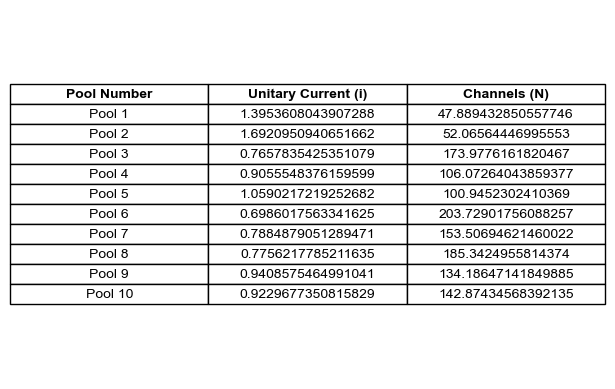

  Pool Number  Unitary Current (i)  Channels (N)
0      Pool 1             1.395361     47.889433
1      Pool 2             1.692095     52.065644
2      Pool 3             0.765784    173.977616
3      Pool 4             0.905555    106.072640
4      Pool 5             1.059022    100.945230
5      Pool 6             0.698602    203.729018
6      Pool 7             0.788488    153.506946
7      Pool 8             0.775622    185.342496
8      Pool 9             0.940858    134.186471
9     Pool 10             0.922968    142.874346


In [15]:

# Create the table using matplotlib
fig, ax = plt.subplots()
ax.axis('off')
table_headers = ["Pool Number", "Unitary Current (i)", "Channels (N)"]
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=table_headers)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the size of the table
for i, header_text in enumerate(table_data[0]):
    cell = table[0, i]
    cell.set_text_props(fontweight='bold')
    
# highlight_cells = [(1, 2),(8,2),(9,2)]  # Example: Highlight cells in the second column and the first row
# for row, col in highlight_cells:
#     cell = table[row, col]
#     cell.set_facecolor('#FFC0CB') 

plt.show()

df = pd.DataFrame(table_data, columns=table_headers)

# Print the DataFrame (optional)
print(df)
# Print the text-based table
# print(text_table)

In [16]:
#MA-P4-B20(pA) Analysis







Analysis Type 3 Chosen


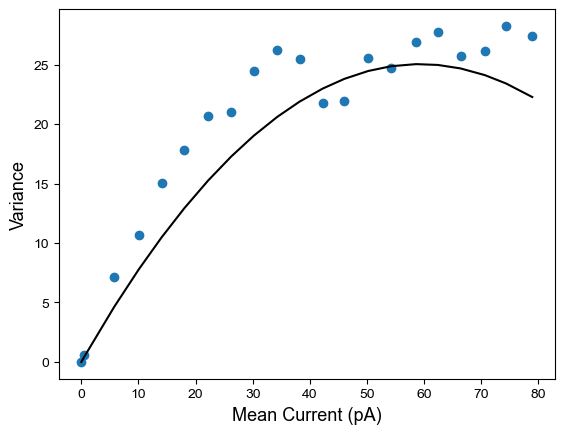

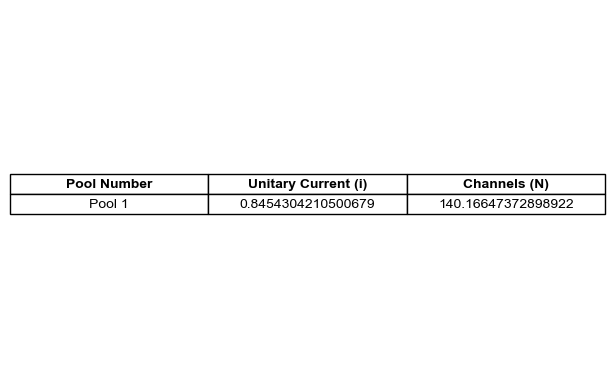

+---------------+-----------------------+----------------+
| Pool Number   |   Unitary Current (i) |   Channels (N) |
+===============+=======================+================+
| Pool 1        |               0.84543 |        140.166 |
+---------------+-----------------------+----------------+


In [17]:
#MA-P1-B0(pA) Analysis

means = mean_calculation(raw_sorted, peak_index,endPoint, segment_indices,pool_indices,3) #Length is Number of Traces X number of decay segments
variances = var_calculation(peak_index, residuals_array,segment_indices,pool_indices,endPoint,3)
B20_coefficients = np.polyfit(means,variances,2)
B20_coefficients[2] = 0
if B20_coefficients[0] >0: 
    B20_coefficients = np.polyfit(means,variances,1)
    B20_coefficients[1] = 0
parabola = np.poly1d(B20_coefficients)
sorter = np.sort(means)
plt.scatter(means,variances)
plt.plot(sorter,parabola(sorter),color="black")
derivative_coefficients = np.polyder(B20_coefficients)
# Create a function representing the derivative
derivative_function = np.poly1d(derivative_coefficients)
roots = np.roots(B20_coefficients)
# Calculate the initial slope at a specific point 
initial_slope = derivative_function(0)
#Calculate the n value
n = roots[0]/initial_slope
plt.rcParams['font.family'] = 'Arial'

# plt.title("Single Pool Mean-Variance Comparison",fontsize=15,fontweight='bold')
plt.xlabel("Mean Current (pA)",fontsize=13)
plt.ylabel("Variance",fontsize=13)
plt.show()

#TABLE
table_data = []
table_data.append([f'Pool 1', initial_slope, n])

fig, ax = plt.subplots()
ax.axis('off')
table_headers = ["Pool Number", "Unitary Current (i)", "Channels (N)"]
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=table_headers)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the size of the table
for i, header_text in enumerate(table_data[0]):
    cell = table[0, i]
    cell.set_text_props(fontweight='bold')

# highlight_cells = [(1, 2),(8,2),(9,2)]  # Example: Highlight cells in the second column and the first row
# for row, col in highlight_cells:
#     cell = table[row, col]
#     cell.set_facecolor('#FFC0CB') 

plt.show()

text_table = tabulate(table_data, headers=table_headers, tablefmt="grid")

# Print the text-based table
print(text_table)






## Create PDF Report for Data ## 

In [18]:
# from reportlab.pdfgen import canvas


# def generate_pdf_report():
#     # Create a PDF report
#     pdf_filename = 'EPSC_report.pdf'
#     c = canvas.Canvas(pdf_filename)

#     # Add text to the PDF
#     text = "EPSC NSFA Analysis for File: " + filename
#     c.drawString(100, 800, text)

#     # Add an image to the PDF
#     color_coded_path = 'Traces-Color-Coded.png'
#     template_path = 'Average-Template.png'
#     mean_var_path = 'Mean-Variance.png'
#     c.drawInlineImage(color_coded_path, 50, 500, width = 250, height = 250)
#     c.drawInlineImage(template_path, 350, 500, width = 250, height = 250)
#     c.drawInlineImage(mean_var_path, 50,200, width = 250, height = 250)
#     slope_text = "Slope of the first two red points is:" + str(coefficients[0])
#     c.drawString(50,50,slope_text)

#     # Save the PDF
#     c.save()


# generate_pdf_report()


# Calculating the Mean and Variance for 20 Decay Segments for each individual EPSC (Method II) # 

Analysis Type 1 Chosen


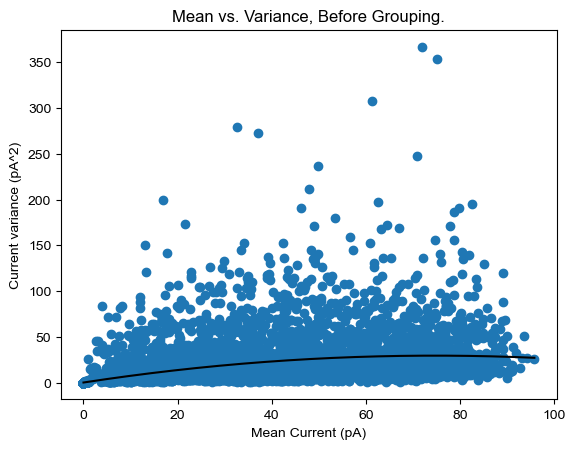

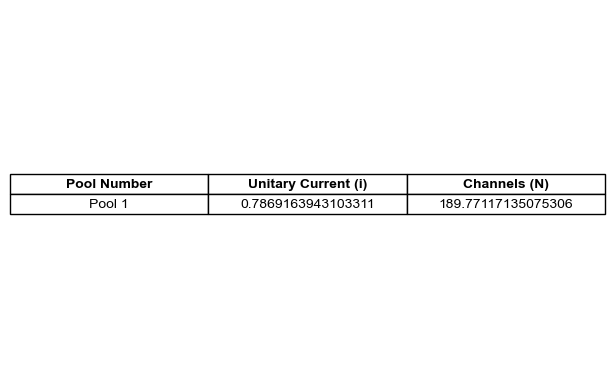

In [19]:
means_2 = mean_calculation(raw_sorted, peak_index,endPoint, segment_indices,pool_indices,1)
variances_2 = var_calculation(peak_index, residuals_array,segment_indices,pool_indices,endPoint,1)

plt.scatter(means_2,variances_2)

plt.xlabel("Mean Current (pA)")
plt.ylabel("Current variance (pA^2)")
plt.title('Mean vs. Variance, Before Grouping.')
coefficients_10 = np.polyfit(means_2, variances_2, 2)
coefficients_10[2] = 0
if coefficients_10[0] > 0: 
    coefficients_10 = np.polyfit(means_2, variances_2, 1)
    coefficients_10[1] = 0


fit_line_2 = np.poly1d(coefficients_10)
sorter_2 = np.sort(means_2)
plt.plot(sorter_2, fit_line_2(sorter_2), color="black")
plt.show()


derivative_coefficients = np.polyder(coefficients_10)
# Create a function representing the derivative
derivative_function = np.poly1d(derivative_coefficients)
roots = np.roots(coefficients_10)
# Calculate the initial slope at a specific point 
initial_slope = derivative_function(0)
#Calculate the n value
n = roots[0]/initial_slope


#TABLE
table_data = []
table_data.append([f'Pool 1', initial_slope, n])

fig, ax = plt.subplots()
ax.axis('off')
table_headers = ["Pool Number", "Unitary Current (i)", "Channels (N)"]
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=table_headers)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the size of the table
for i, header_text in enumerate(table_data[0]):
    cell = table[0, i]
    cell.set_text_props(fontweight='bold')







# ##Compare to Jim's Results
# jim_means = comp_data[:,0]
# jim_vars = comp_data[:,1]
# plt.scatter(jim_means,jim_vars)
# plt.xlabel("Mean Current (pA)")
# plt.ylabel("Current variance (pA^2)")
# plt.title('Mean vs. Variance, from Excel Directly')
# plt.show()



## Grouping Mean-Var Pairs By Size of Mean ##

In [20]:
mean_var_pairs_2 = list(zip(means_2, variances_2))
sorted_pairs = sorted(mean_var_pairs_2, key=lambda x: x[0])
sorted_pairs = np.array(sorted_pairs)
print(sorted_pairs)

bin_width = (np.max(means_2) - np.min(means_2)) / num_decay_segments

# #Defining the cutoff points for each group of means
# largest_mean = np.max(means_2)
# a = largest_mean
# cutoffs = [] 
# for i in range(num_decay_segments):
#     a = a - bin_width
#     if a > 0: 
#         cutoffs.append(a)

# cutoffs.reverse()
# cutoffs.append(largest_mean)
# bin_indices = []
# bin_indices.append(0)

# #Using those cutoff points, determine which index in sorted_pairs corresponds to those points
# for cutpoint in cutoffs: 
#     index = 0 
#     for pair in sorted_pairs: 
#         if pair[0] >= cutpoint:  #If the mean of the pair >= cutoff
#             bin_indices.append(index-1)
#             break
#         index +=1 
# # print("Cutoffs:", cutoffs)
# # print("Bin Indices:", bin_indices)


# #########
# group_means_2 = []
# group_var_2 = []

# # comp_group_means = []
# # comp_group_vars = []

# for index in range(len(bin_indices)-1): 
#     lower_ind = bin_indices[index]
#     upper_ind = bin_indices[index+1]
#     slice_pairs =sorted_pairs[lower_ind:upper_ind] 
#     # Calculate the average of means and variances for the current slice
#     if index == 9:
#         print(f"Slice Pairs {index}:", slice_pairs)
#     mean_sum = sum(pair[0] for pair in slice_pairs)
#     var_sum = sum(pair[1] for pair in slice_pairs)
#     group_means_2.append(mean_sum / len(slice_pairs))
#     group_var_2.append(var_sum / len(slice_pairs))
    

# # for index in range(len(bin_indices)-1): 
# #     lower_ind = bin_indices[index]
# #     upper_ind = bin_indices[index+1]
# #     slice_pairs =comp_mean_var_pairs[lower_ind:upper_ind] 
# #     # Calculate the average of means and variances for the current slice
# #     mean_sum = sum(pair[0] for pair in slice_pairs)
# #     var_sum = sum(pair[1] for pair in slice_pairs)

# #     comp_group_means.append(mean_sum / len(slice_pairs))
# #     comp_group_vars.append(var_sum / len(slice_pairs))

# x_fit = group_means_2
# y_fit = group_var_2
# coefficients = np.polyfit(x_fit, y_fit, 2)
# coefficients[2] = 0
# fit_line = np.poly1d(coefficients)

# print(coefficients)

# #Plot the linear fit line and scatterplot
# plt.plot(x_fit, fit_line(x_fit), color='black', label='Linear Fit to 15 points')
# plt.title("Mean-Var Comparison: Pipeline")
# plt.xlabel("Mean Current (pA)")
# plt.ylabel("Current variance (pA^2)")
# plt.scatter(group_means_2,group_var_2, color ="orange")
# plt.show()





# derivative_coefficients = np.polyder(coefficients)
# # Create a function representing the derivative
# derivative_function = np.poly1d(derivative_coefficients)
# roots = np.roots(coefficients)
# # Calculate the initial slope at a specific point 
# initial_slope = derivative_function(0)
# #Calculate the n value
# n = roots[0]/initial_slope




# table_data = []
# table_data.append([f'Pool 1', initial_slope, n])

# fig, ax = plt.subplots()
# ax.axis('off')
# table_headers = ["Pool Number", "Unitary Current (i)", "Channels (N)"]
# table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=table_headers)

# table.auto_set_font_size(False)
# table.set_fontsize(10)
# table.scale(1.2, 1.2)  # Adjust the size of the table
# for i, header_text in enumerate(table_data[0]):
#     cell = table[0, i]
#     cell.set_text_props(fontweight='bold')





# # #Repeat process for comparison group
# # x_fit_2 = comp_group_means[:14]
# # y_fit_2 = comp_group_vars[:14]
# # coefficients_2 = np.polyfit(x_fit, y_fit, 1)
# # fit_line = np.poly1d(coefficients)
# # plt.title("Mean-Var Comparison: Excel")
# # plt.xlabel("Mean Current (pA)")
# # plt.ylabel("Current variance (pA^2)")
# # plt.plot(x_fit_2, fit_line(x_fit_2), color='black', label='Linear Fit to 15 points')
# # plt.scatter(comp_group_means,comp_group_vars, color = "orange")



[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 ...
 [93.55294118 50.95960696]
 [94.15       26.38615166]
 [95.76470588 25.99256741]]


## Mutable Number of Pools for Method II ## 

- We have raw data for EPSCs. 
- We sorted the EPSCs by peak size. 
- We pool the EPSCs by peak size. 
- We run the MV method II on those EPSCs. 
- The MV within each pool are preserved. 
- The MV pairs are sorted by mean within each pool. 
- The MV pairs are binned by mean size cutoffs within each pool. 
    - OR, the MV pairs are binned by an equal number of MV pairs wihtin each pool. 
- Within those bins, the average mean and average variance are taken. 
- For a bin, (average-mean, average-variance) defines one point on the graph

In [21]:
#Part 1: Find the indices for a variable number of bins. 


#We have 4000 points. We want to pool these points by percentile. I.E if we want each to represent 10%, we will have bin widths of min-max/10. 
#If we wanted to have 4 pools, that means each would be 25% of the max. We should divide min-max/4. 

#Sorted_pairs is sorted by means from smallest to largest right now. We found bin indices before by taking the TEMPLATE of the data and calculating from there



#Sort the raw traces by their (means) from smallest to largest: sorted_pairs fulfills this


current_interval_width = (np.max(raw_sorted[peak_index,:])-np.min(raw_sorted[peak_index,:]))/num_pools
#The equivalent is finding the max of the MEANS 


pool_indices = []
bin_cutoffs = []

highest_peak = np.max(raw_sorted[peak_index ,:]) 
cutoff = highest_peak 
for i in range(10):
    cutoff = cutoff - current_interval_width
    bin_cutoffs.append(cutoff)
bin_cutoffs = np.flip(bin_cutoffs) #Order it from smallest to largest
print("The pool cutoffs are: ", bin_cutoffs) #Confirmed the same as with excel doc

bins = []
for cutpoint in bin_cutoffs: 
    index = 0 
    for value in raw_sorted[peak_index,:] : 
        if value >= cutpoint: 
            pool_indices.append(index)
            break
        index +=1 

pool_indices.append(endPoint)
print("Pool Indices:", pool_indices) #this is the index of where the bins begin in terms of the peak row


The pool cutoffs are:  [54.   58.88 63.76 68.64 73.52 78.4  83.28 88.16 93.04 97.92]
Pool Indices: [1, 2, 5, 17, 42, 81, 125, 165, 185, 194, 800]


In [22]:
import pandas as pd
raw_sorted = EPSCs[:, EPSCs[peak_index, :].argsort()]

#1. Find the pool indices from the peak index row in the raw data. These should be percentile based.

def pool_data(raw_sorted,num_pools,peak_index):
    # Create a list of random numbers
    data_to_pool = raw_sorted[peak_index ,:]

    # Convert the list to a pandas Series
    data_series = pd.Series(data_to_pool)

    # Specify bin edges for cut
    pool_edges = np.linspace(min(data_to_pool), max(data_to_pool), num_pools+1)

    # Use cut to discretize the data into num_pool amount of pools
    pooled_data = pd.cut(data_series, bins=pool_edges,include_lowest=True)

    # Convert the Series back to a list of lists
    pooled_result = [list(group) for _, group in data_series.groupby(pooled_data)]
    
        # Get cutoff indices for where each bin ends
    cutoff_indices = [
        data_series.index[group.index[-1]]+1 if not group.empty else None
        for _, group in data_series.groupby(pooled_data)
    ]

    return cutoff_indices

    

pool_indices = pool_data(raw_sorted,num_pools+1, peak_index)
print(len(pool_indices))

#2. Each EPSC should go through the mean-variance analysis. These pairs should maintain their columns from the raw data
means_4 = mean_calculation(raw_sorted, peak_index,endPoint, segment_indices,pool_indices,4)
print(means_4.shape)
variances_4 = var_calculation(peak_index, residuals_array,segment_indices,pool_indices,endPoint,4)


#3. Now that the analysis is done, we want to combine them into one array. 

def combine_arrays(*arrays):
    # Ensure all arrays have the same shape
    shapes = [arr.shape for arr in arrays]
    if len(set(shapes)) != 1:
        raise ValueError("All input arrays must have the same shape.")

    # Combine arrays into a new array of tuples
    combined_array = np.dstack(arrays)

    # Reshape to have the same shape as the input arrays
    combined_array = combined_array.reshape(shapes[0] + (len(arrays),))

    return combined_array

combined_mv = combine_arrays(means_4, variances_4)


# Next we want to create blocks of data defined in columns by pool-indices and in row by whatever binning method we use. 
#That will also require us to sort the data. Pd automatically does take care of that though. 

#Step 1... group our mean-variance pairs by the pool_indices


group_means_3 = []
group_var_3 = []


def create_bin_cutoffs(mean_elements,binning_type, num_bins=5,num_data_per_bin=10):
    max_mean = max(mean_elements)
    min_mean = min(mean_elements)
    print("Length:,", len(mean_elements))
    if binning_type == "percentiles": #Allows you to determine the number of bins total for each pool
        bin_edges = np.linspace(min_mean,max_mean,num_bins+1)
        data_series = pd.Series(mean_elements)
        # Use cut to discretize the data into  bins (pools)
        binned_data = pd.cut(data_series, bins=bin_edges,include_lowest=True)
        # Get cutoff indices for where each bin ends
        cutoff_indices = [
            data_series.index[group.index[-1]]+1 if not group.empty else None
            for _, group in data_series.groupby(binned_data)
        ]
    elif binning_type == "equal_width_bins": #Allows you to determine the width (how many data points) of each bin
        total_bins = len(mean_elements)//num_data_per_bin #Number of bins required
        cutoff_indices = [(i + 1) * num_data_per_bin for i in range(total_bins)]

    
    return cutoff_indices
    


for index in range(len(pool_indices)-1): 
    lower = pool_indices[index]
    upper = pool_indices[index+1]
    array_block_to_bin = combined_mv[:, lower:upper]
    #Reshape the block to a single vector of tuples
    vector_of_tuples = array_block_to_bin.reshape(-1, 2)
    #Sort by means
    vector_of_tuples = vector_of_tuples[vector_of_tuples[:,0].argsort()]
    mean_elements = vector_of_tuples[:, 0]
    #Find the indices that will give you your bin size 
    bin_indices = create_bin_cutoffs(mean_elements, binning_type="percentiles",num_bins=20)    ##Changeable bin sizes. Your desired size + 1
    print("Bin Indices:", bin_indices)
    #...Now we bin the vector by the size of the means
    temp_list_means = []
    temp_list_vars = []
    for bin_index in range(len(bin_indices)-1):
        if bin_index == 0: 
            lower_vec_ind = 0
            upper_vec_ind = bin_indices[bin_index]
        else:
            lower_vec_ind = bin_indices[bin_index]
            upper_vec_ind = bin_indices[bin_index+1]
        vector_bin_slice = vector_of_tuples[lower_vec_ind:upper_vec_ind]
        #Check for faulty vectors
        if (len(vector_bin_slice) == 0):
            print(f"Faulty bin slice for {lower_vec_ind} to {upper_vec_ind}")
        if (len(vector_bin_slice) !=0):
#             print(f"Good bin slice for {lower_vec_ind} to {upper_vec_ind}")
            mean_sum = sum(pair[0] for pair in vector_bin_slice)
            var_sum = sum(pair[1] for pair in vector_bin_slice)
            temp_list_means.append(mean_sum / len(vector_bin_slice))
#             print(temp_list_means)
            temp_list_vars.append(var_sum / len(vector_bin_slice))
    group_means_3.append(temp_list_means)
    group_var_3.append(temp_list_vars)

print(len(group_means_3))
print(len(group_var_3))
# group_means_3 = np.array(group_means_3)
# # group_means_3 = group_means_3.flatten()
# print(group_means_3)






11
(21, 199)
Analysis Type: Individual Traces (Pooling) Chosen
Length:, 42
Bin Indices: [5, 9, 10, 12, 14, 15, 17, 18, 20, 21, 22, 24, 26, 28, 30, 33, 35, 36, 40, 42]
Length:, 210
Bin Indices: [25, 35, 43, 57, 69, 81, 94, 99, 112, 119, 130, 139, 154, 161, 173, 185, 198, 203, 208, 210]
Length:, 294
Bin Indices: [31, 48, 62, 76, 89, 104, 123, 136, 149, 166, 179, 194, 207, 228, 240, 256, 265, 279, 288, 294]
Length:, 672
Bin Indices: [77, 108, 149, 183, 216, 246, 288, 315, 349, 376, 423, 457, 493, 528, 557, 591, 622, 652, 669, 672]
Length:, 777
Bin Indices: [84, 122, 158, 202, 238, 272, 322, 358, 393, 433, 483, 519, 558, 597, 628, 671, 701, 739, 768, 777]
Length:, 924
Bin Indices: [104, 150, 198, 244, 281, 332, 380, 429, 477, 533, 580, 632, 672, 724, 770, 812, 852, 891, 913, 924]
Length:, 714
Bin Indices: [82, 116, 151, 193, 227, 265, 303, 341, 372, 414, 444, 477, 517, 547, 581, 613, 644, 678, 699, 714]
Length:, 273
Bin Indices: [27, 37, 47, 66, 83, 96, 106, 121, 134, 151, 166, 181, 193, 2

Above zero
Above zero
Above zero


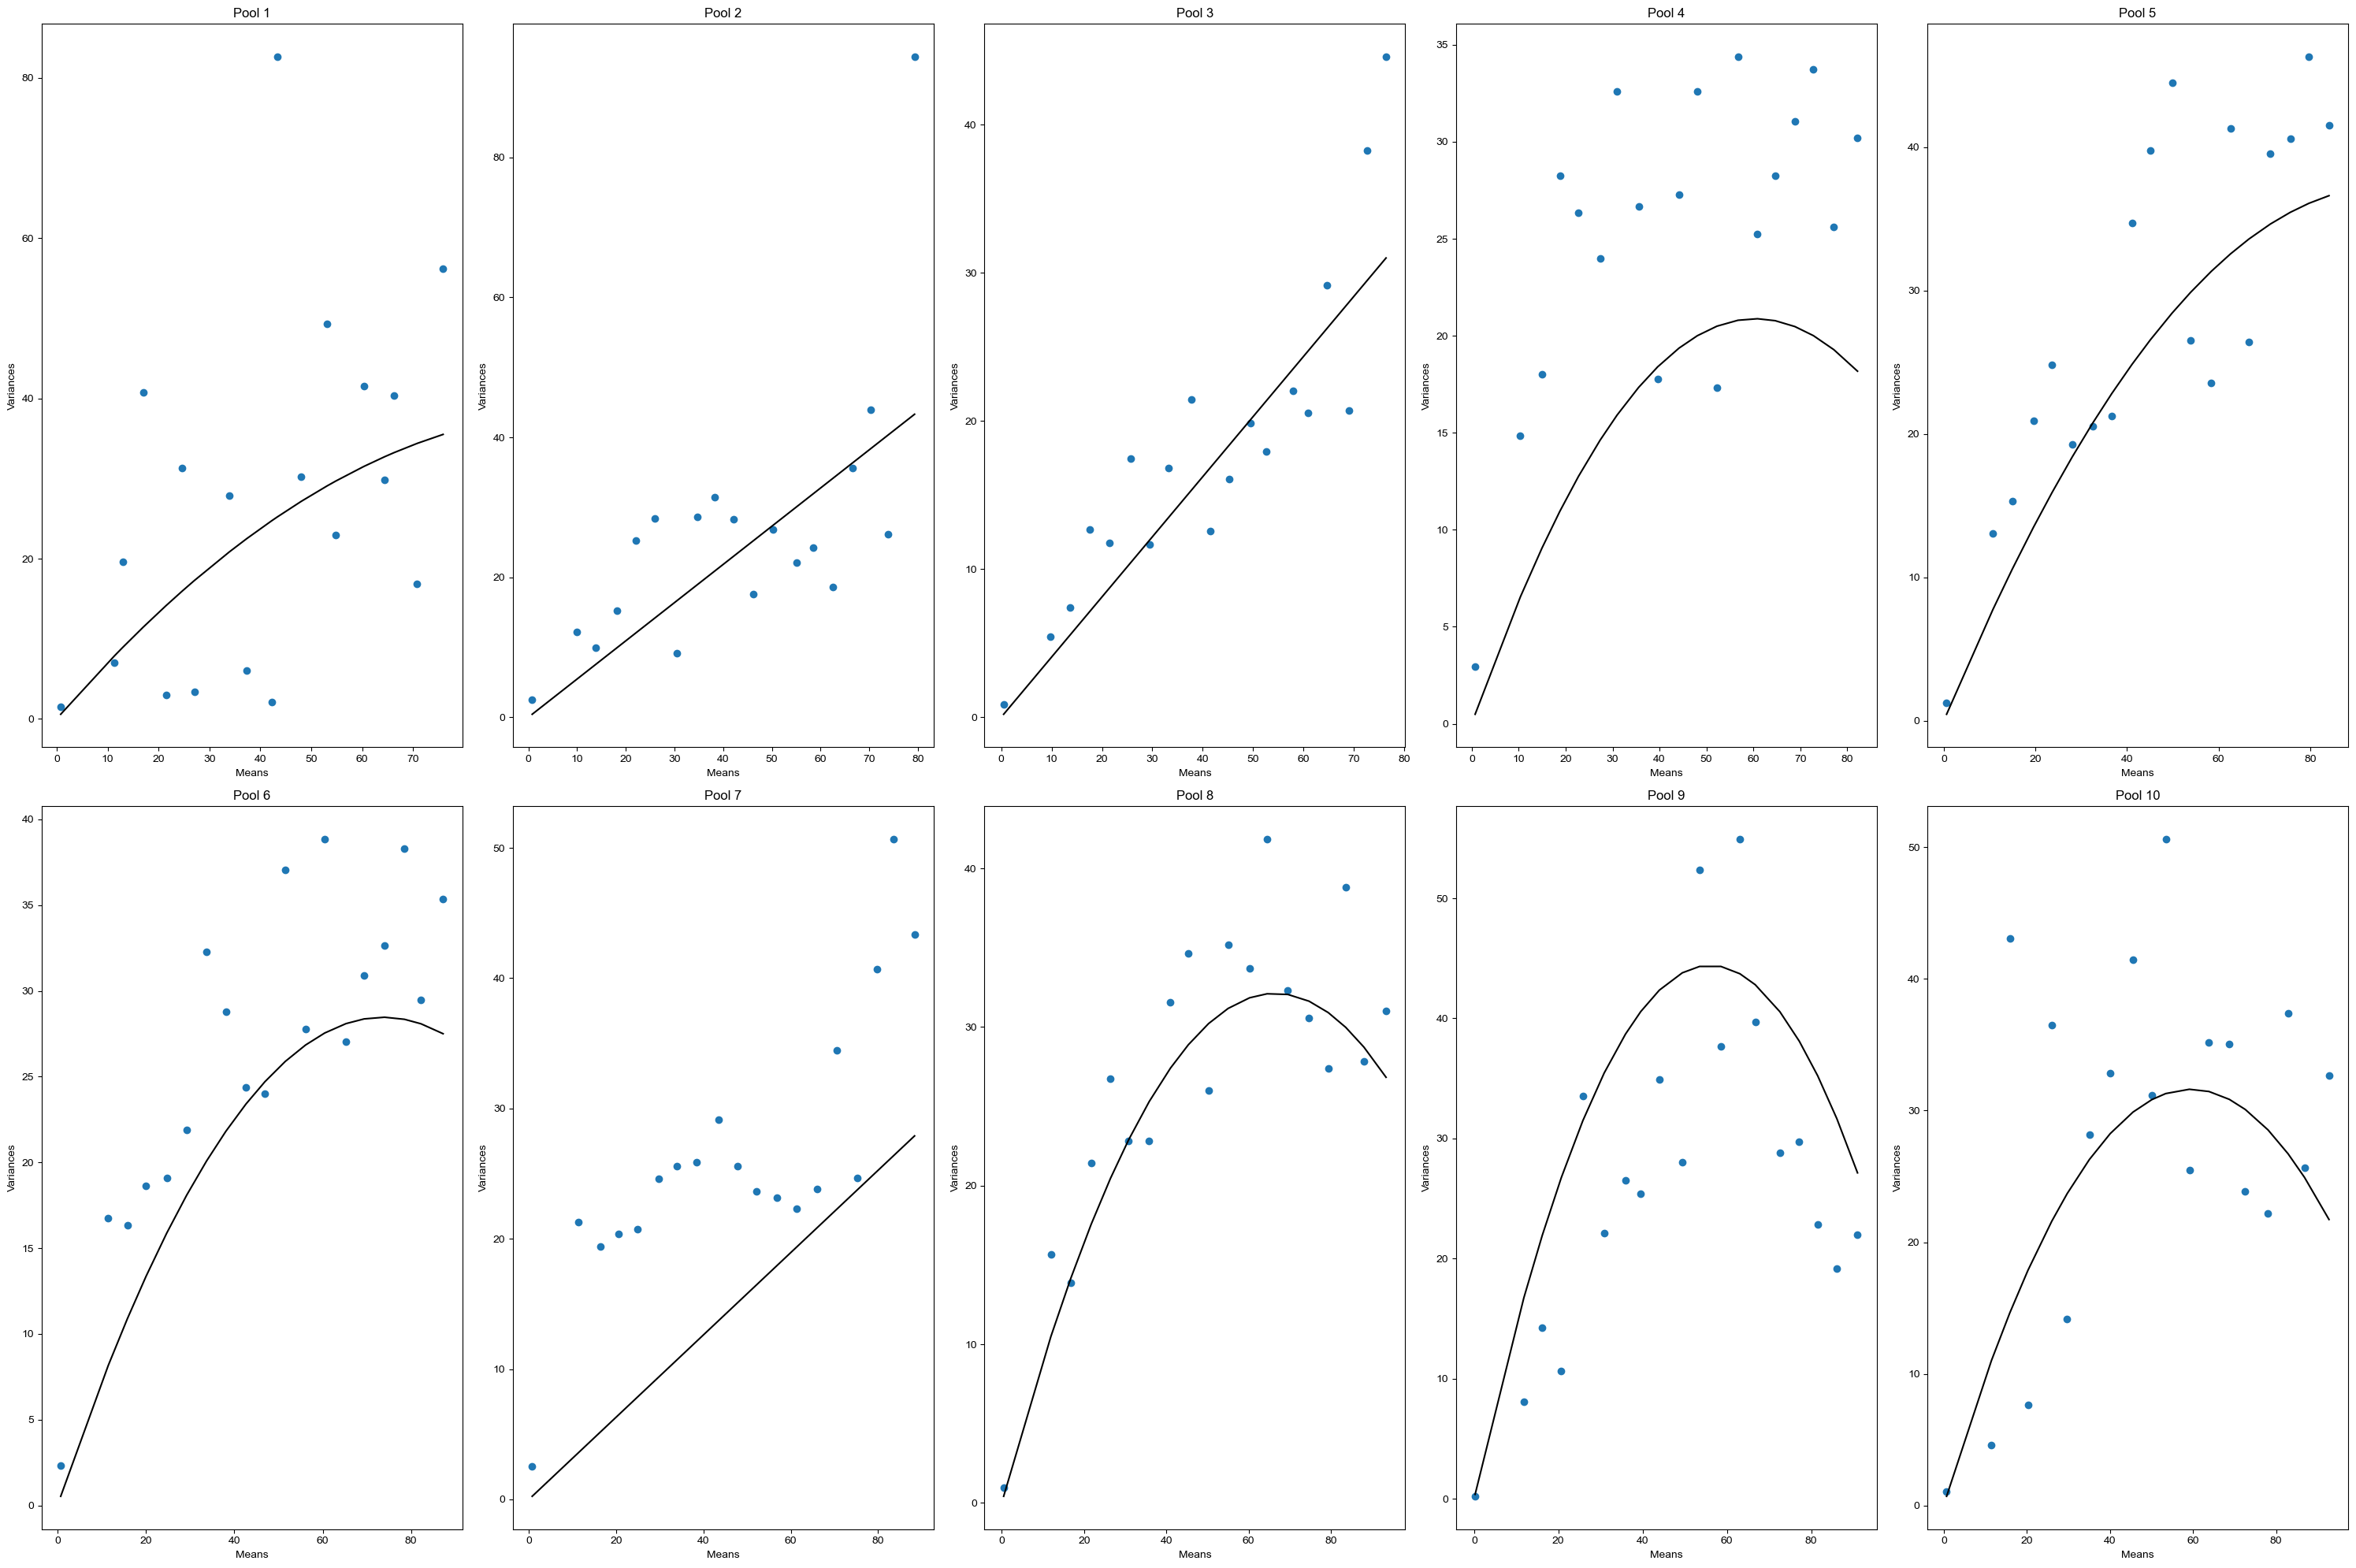

In [23]:
method_II_table = []
if len(group_means_3) == 10:
    graph_rows = 5
if len(group_means_3) == 4:
    graph_rows = 2

figs, axs = plt.subplots(2,graph_rows, figsize = (30,20))
axs = axs.flatten()
for index, m_list in enumerate(group_means_3):
    axs[index].scatter(m_list,group_var_3[index])
    parabolic_parameters = np.polyfit(m_list,group_var_3[index],2)
    parabolic_parameters[2] = 0
    if parabolic_parameters[0] > 0: 
        print("Above zero")
        parabolic_parameters =  np.polyfit(m_list,group_var_3[index],1)
        parabolic_parameters[1] = 0
#     parabolic_parameters[0] = -abs(parabolic_parameters[0])
    parabolic_fit = np.poly1d(parabolic_parameters)
    sorter = np.sort(m_list)
    axs[index].plot(sorter, parabolic_fit(sorter), color='black')
    axs[index].set_title(f'Pool {index+1}')
    axs[index].set_xlabel('Means')
    axs[index].set_ylabel('Variances')
    derivative_coefficients = np.polyder(parabolic_parameters)
    # Create a function representing the derivative
    derivative_function = np.poly1d(derivative_coefficients)
    # Calculate the initial slope at a specific point (e.g., x=1)
    initial_slope = derivative_function(0)
    roots = np.roots(parabolic_parameters)
    n = roots[0]/initial_slope

#     axs[index].text(0, -.15, f'Slope of initial parab: {initial_slope} \n n count: {n} \n coefficients: {co_regularized} ', transform=axs[index].transAxes)
    method_II_table.append([f'Pool {index+1}', initial_slope, n])

    

plt.tight_layout()
plt.show()
    

        








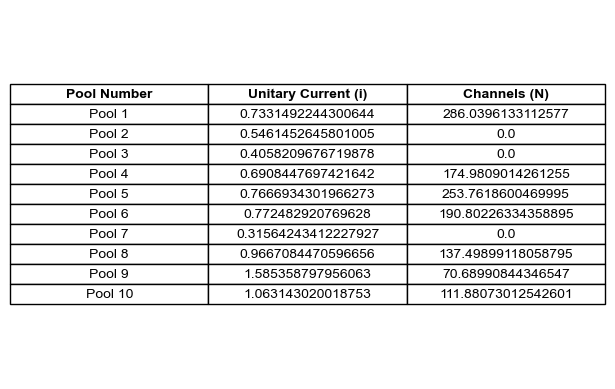

In [24]:
# Create the table using matplotlib
fig, ax = plt.subplots()
ax.axis('off')
table_headers = ["Pool Number", "Unitary Current (i)", "Channels (N)"]
table = ax.table(cellText=method_II_table, loc='center', cellLoc='center', colLabels=table_headers)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the size of the table
for i, header_text in enumerate(method_II_table[0]):
    cell = table[0, i]
    cell.set_text_props(fontweight='bold')
    
# highlight_cells = [(1, 2),(8,2),(9,2)]  # Example: Highlight cells in the second column and the first row
# for row, col in highlight_cells:
#     cell = table[row, col]
#     cell.set_facecolor('#FFC0CB') 

plt.show()

[2, 4, 14, 28, 60, 97, 141, 175, 188, 195, 199]


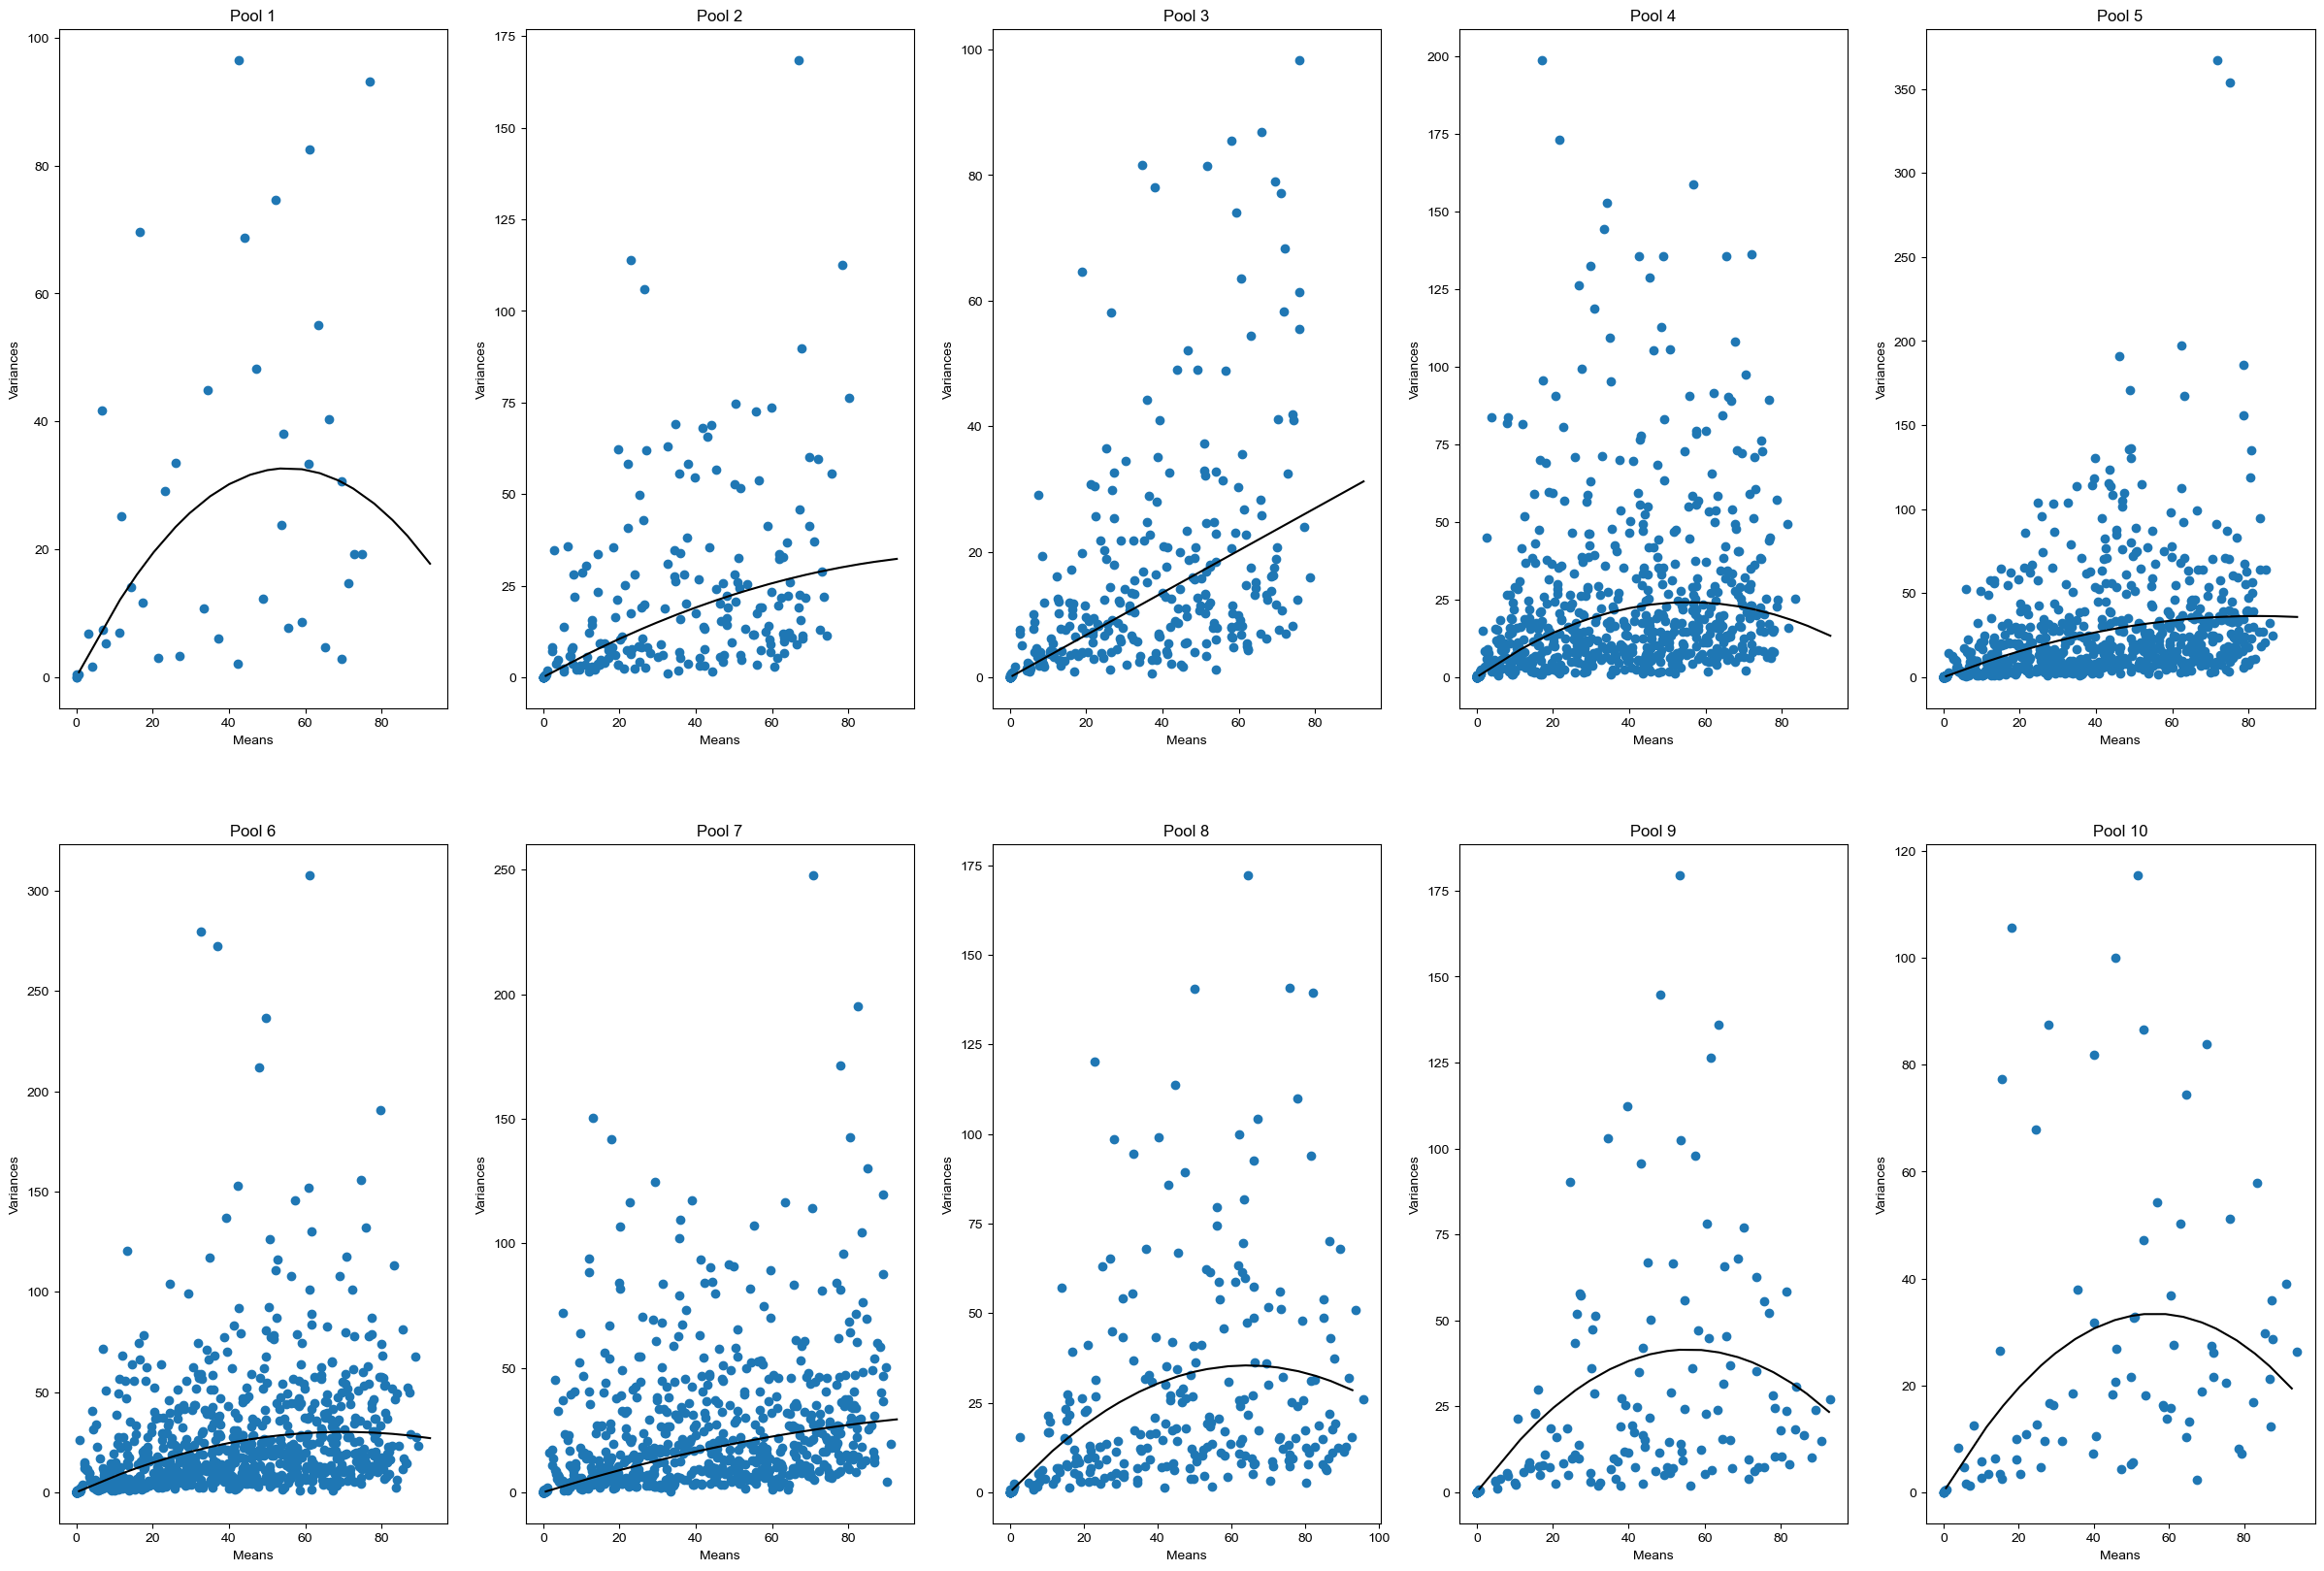

In [25]:
#FOR D4b-MB-P4-B0
print(pool_indices)
if len(group_means_3) == 10:
    graph_rows = 5
if len(group_means_3) == 4:
    graph_rows = 2

figs, axs = plt.subplots(2,graph_rows, figsize = (30,20))
axs = axs.flatten()
table_data = []

for index in range(len(pool_indices)-1): 
    lower = pool_indices[index]
    upper = pool_indices[index+1]
    array_block_to_bin = combined_mv[:, lower:upper]
    #Reshape the block to a single vector of tuples
    vector_of_tuples = array_block_to_bin.reshape(-1, 2)
    #Sort by means
    vector_of_tuples = vector_of_tuples[vector_of_tuples[:,0].argsort()]
    means, variances = zip(*vector_of_tuples)
    axs[index].scatter(means, variances)
    #plotting
    parabolic_parameters = np.polyfit(means,variances,2)
    parabolic_parameters[2] = 0
    if parabolic_parameters[0] > 0: 
        parabolic_parameters =  np.polyfit(m_list,group_var_3[index],1)
        parabolic_parameters[1] = 0
    parabolic_fit = np.poly1d(parabolic_parameters)
    sorter = np.sort(m_list)
    axs[index].plot(sorter, parabolic_fit(sorter), color='black')
    axs[index].set_title(f'Pool {index+1}')
    axs[index].set_xlabel('Means')
    axs[index].set_ylabel('Variances')
    derivative_coefficients = np.polyder(parabolic_parameters)
    # Create a function representing the derivative
    derivative_function = np.poly1d(derivative_coefficients)
    # Calculate the initial slope at a specific point (e.g., x=1)
    initial_slope = derivative_function(0)
    roots = np.roots(parabolic_parameters)
    n = roots[0]/initial_slope

#     axs[index].text(0, -.15, f'Slope of initial parab: {initial_slope} \n n count: {n} \n coefficients: {co_regularized} ', transform=axs[index].transAxes)
    table_data.append([f'Pool {index+1}', initial_slope, n])











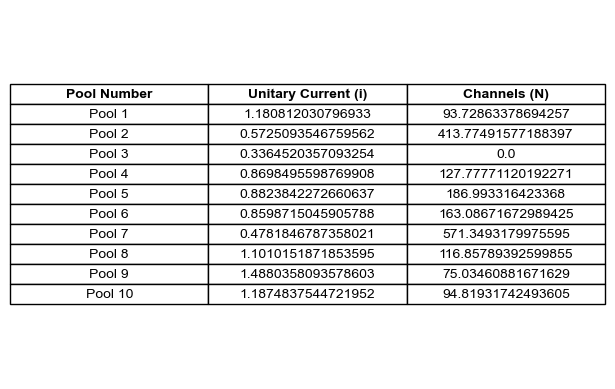

In [26]:
# Create the table using matplotlib
fig, ax = plt.subplots()
ax.axis('off')
table_headers = ["Pool Number", "Unitary Current (i)", "Channels (N)"]
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=table_headers)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the size of the table
for i, header_text in enumerate(method_II_table[0]):
    cell = table[0, i]
    cell.set_text_props(fontweight='bold')
    
# highlight_cells = [(1, 2),(8,2),(9,2)]  # Example: Highlight cells in the second column and the first row
# for row, col in highlight_cells:
#     cell = table[row, col]
#     cell.set_facecolor('#FFC0CB') 

plt.show()

In [27]:
# ##Bin by equal number in each
 
# def create_equal_size_bins(pool_indices,combined_mv, num_bins): 
#     binned_pools = []
#     for index in range(len(pool_indices)-1): 
#         lower = pool_indices[index]
#         upper = pool_indices[index+1]
#         array_block_to_bin = combined_mv[:, lower:upper]
#         #...Reshape the block to a single vector of tuples
#         vector_of_tuples = array_block_to_bin.reshape(-1, 2)
#         sorted_vector = sorted(vector_of_tuples, key=lambda x: x[0])     

# #         binned_vector = [sorted_vector[i:i + num_bins] for i in range(0, len(sorted_vector), num_bins)]
        
# #         binned_pools.append(binned_vector)
# #     print("Shape of Your Array:", len(binned_pools[2]))
#     return binned_pools

    
# binned_pools = create_equal_size_bins(pool_indices,combined_mv, 10)

# print(binned_pools)

        
        
# print(binned_pools[0][0][0])      




# Separate the tuples into two lists for x and y coordinates
# print(binned_pools[0])

# Assuming binned_pools is a list of lists, similar to the example in your previous questions

# Create a figure with as many subplots as the length of binned_pools
fig, axs = plt.subplots(nrows=len(binned_pools)-1, figsize=(8, 6 * (len(binned_pools)-1)))

for i in range(len(binned_pools)-1):
    x_values, y_values = zip(*[(item[0], item[1]) for item in binned_pools[i]])

    # Plot the first element against the second element in the i-th subplot
    axs[i].scatter(x_values, y_values)

    # Add labels and a legend for each subplot
    axs[i].set_xlabel('Means')
    axs[i].set_ylabel('Variances')
    axs[i].set_title(f'Means v Variances - Bin {i+1}')
    axs[i].legend()
    print("Just means:", y_values)
    coefficients_unreg = np.polyfit(x_values,y_values,2)
    fit_parab = np.poly1d(coefficients_unreg)
    roots = np.roots(coefficients_unreg)
    axs[i].plot(x_values, fit_parab(x_values), color='black', label='Parabolic Fit')
    derivative_coefficients = np.polyder(coefficients_unreg)

    # Create a function representing the derivative
    derivative_function = np.poly1d(derivative_coefficients)

    # Calculate the initial slope at a specific point (e.g., x=1)
    initial_slope = derivative_function(1)
    #Calculate the n value
    n = roots[0]/initial_slope
    axs[i].text(0, -.15, f'Slope of initial parab: {initial_slope} \n n count: {n} \n coefficients: {co_regularized} ', transform=axs[i].transAxes)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


NameError: name 'binned_pools' is not defined

In [ ]:
##Experimental Code ##

In [ ]:
import numpy as np

# Create a sample array (20, 200, 2) of tuples
array_of_tuples = np.random.rand(20, 200, 2)

# Reshape the array to a 1D array of tuples

# Print the result
print(vector_of_tuples)


In [ ]:
import pandas as pd
import numpy as np
import random


def pool_data(raw_sorted,num_pools,peak_index):
    # Create a list of random numbers
    data_to_pool = raw_sorted[peak_index ,:]

    # Convert the list to a pandas Series
    data_series = pd.Series(data_to_pool)

    # Specify bin edges for cut
    pool_edges = np.linspace(min(data_to_pool), max(data_to_pool), num_pools+1)

    # Use cut to discretize the data into 10 bins (pools)
    pooled_data = pd.cut(data_series, bins=pool_edges,include_lowest=True)

    # Convert the Series back to a list of lists
    pooled_result = [list(group) for _, group in data_series.groupby(pooled_data)]
    
        # Get cutoff indices for where each bin ends
    cutoff_indices = [
        data_series.index[group.index[-1]]+1 if not group.empty else None
        for _, group in data_series.groupby(pooled_data)
    ]

    return pool_indices

    


# def bin_data(pooled_result,num_bins):


pool_indices = pool_data(raw_sorted,4, peak_index)











# num_bins = 4
# binned_result = []
# # Print the result
# for i, pool_values in enumerate(pooled_result):
# #     print(f"Pool {i}: {pool_values}")
#     bin_edges = np.linspace(min(pool_values), max(pool_values), num_bins+1)
# #     print(bin_edges)
#     data_series = pd.Series(pool_values)
#     binned_data = pd.cut(data_series, bins=bin_edges,include_lowest=True,duplicates='drop')
#     if i == 0:
#         [print(group) for _,group in data_series.groupby(binned_data)]
    

    
    
    
# Pool Indices: [0, 7, 46, 97, 148, 165, 184, 192, 198, 199, 599]

In [ ]:
import matplotlib.pyplot as plt

# Data for the table
table_data = [
    ["Name", "Age", "City"],
    ["Alice", 25, "New York"],
    ["Bob", 30, "San Francisco"],
    ["Charlie", 22, "Los Angeles"]
]

# Create a figure and axis
fig, ax = plt.subplots()

# Hide axes
ax.axis('off')

# Create the table
table = ax.table(cellText=table_data, loc='center', cellLoc='center', colLabels=None)

# Customize the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust the size of the table

plt.show()


In [ ]:
import numpy as np

# Define coefficients of a polynomial (ax^2 + bx + c)
coefficients = [1, -3, 2]

# Find the roots of the polynomial
roots = np.roots(coefficients)

print("Polynomial Coefficients:", coefficients)
print("Roots:", roots)


In [ ]:
ex = np.linspace(198.473,955.977,10)
print(ex)

In [ ]:
x = [1,2,3]
print(x[0:0])